In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import shap

module_path = (Path().resolve().parent/ "Modules")
sys.path.append(str(module_path))

import my_modules, model_tuner, model_tuner_multi, features, skill_calculators, feature_selector
pd.set_option("display.max_columns", None)
pd.option_context(
        'display.max_info_rows', None,     # 行しきい値を無制限
        'display.max_info_columns', None
        )

plt.rcParams['font.family'] = 'Yu Gothic'

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

c:\Users\ken05\Documents\others\HORSE_RACING\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("../Data/train_data_JV_2008.csv", encoding="cp932")
# odds_df = pd.read_csv("../Data/Time_Series_Odds_win_odds.csv", encoding="shift-jis")

In [3]:
df2 = my_modules.preprocessing(df)

In [4]:
df3 = my_modules.common_process(df2)

C:\Users\ken05\Documents\others\HORSE_RACING\Modules\my_modules.py:77: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["place_num"] = df["place"].replace(place_dict).astype(int)


In [5]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 829624 entries, 830948 to 0
Data columns (total 71 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   race_id              829624 non-null  int64         
 1   year                 829624 non-null  int64         
 2   month                829624 non-null  int64         
 3   day                  829624 non-null  int64         
 4   times                829624 non-null  int64         
 5   place                829624 non-null  object        
 6   daily                829624 non-null  object        
 7   race_num             829624 non-null  int64         
 8   horse                829624 non-null  object        
 9   jockey_id            829624 non-null  object        
 10  trainer_id           829624 non-null  int64         
 11  owner                829624 non-null  object        
 12  breeding_farm        829624 non-null  object        
 13  breeding_place     

In [6]:
# 計算に時間がかかりすぎるので、とりあえず2020年からのデータをつかって実験
df3 = df3[df3.year >= 2018]

In [7]:
feature_col = []
ranking_col = []
df4, feature_col2, ranking_col2 = skill_calculators.all_rating_calculator(df3, feature_col, ranking_col)

calculating horse trueskill is in progress
calculating jockey trueskill is in progress
calculating horse EloRating is in progress
calculating jockey EloRating is in progress
calculating horse Glicko2 is in progress
calculating jockey Glicko2 is in progress
poly calculated


In [8]:
feature_col2.extend(["waku_num", "horse_num", "sex", "age", "basis_weight", "weight", "inc_dec", "age_type"])

In [9]:
df5, feature_col3 = features.sub_feature_engineering(df4, feature_col2, ranking_col2)

calc grouped rating caluculated
group_winning_rate_calculated
added last odds
num_col are standardize
calculated rankings
['horse_TrueSkill', 'horse_TrueSkill_sigma', 'horse_TrueSkill_min', 'horse_TrueSkill_max', 'jockey_TrueSkill', 'jockey_TrueSkill_sigma', 'jockey_TrueSkill_min', 'jockey_TrueSkill_max', 'horse_EloRating', 'jockey_EloRating', 'horse_Glicko2', 'horse_Glicko2_RD', 'horse_Glicko2_min', 'horse_Glicko2_max', 'jockey_Glicko2', 'jockey_Glicko2_RD', 'jockey_Glicko2_min', 'jockey_Glicko2_max', 'horse_TrueSkill_diff_from_last1_racing', 'horse_TrueSkill_diff_from_last3_racing', 'jockey_TrueSkill_diff_from_last1_racing', 'jockey_TrueSkill_diff_from_last3_racing', 'horse_EloRating_diff_from_last1_racing', 'horse_EloRating_diff_from_last3_racing', 'jockey_EloRating_diff_from_last1_racing', 'jockey_EloRating_diff_from_last3_racing', 'horse_Glicko2_diff_from_last1_racing', 'horse_Glicko2_diff_from_last3_racing', 'horse_TrueSkill horse_TrueSkill_min', 'horse_TrueSkill horse_TrueSkill_

,race_id,year,month,day,times,place,daily,race_num,horse,jockey_id,trainer_id,owner,breeding_farm,breeding_place,horse_N,waku_num,horse_num,class_code,track_code,corner_num,dist,state,weather,age_code,sex,age,basis_weight,blinker,weight,inc_dec,weight_code,win_odds,win_mul_odds_Hi,win_mul_odds_Lo,rank,time_diff,time,corner1_rank,corner2_rank,corner3_rank,corner4_rank,last_3F_time,last_3F_rank,Ave_3F,PCI,PCI3,RPCI,last_3F_time_diff,leg,pop,prize,error_code,father,mother,broodmare_sire,broodmare_sire_type,horse_color,id,id_for_fold,field_type,flat_or_jump,turn_type,race_type,waku,datetime,season,age_type,dist_type,is_1st_rank,is_in_3rd_rank,target,horse_TrueSkill,horse_TrueSkill_sigma,horse_TrueSkill_min,horse_TrueSkill_max,horse_TrueSkill_after_racing,jockey_TrueSkill,jockey_TrueSkill_sigma,jockey_TrueSkill_min,jockey_TrueSkill_max,jockey_TrueSkill_after_racing,horse_EloRating,horse_EloRating_after_racing,jockey_EloRating,jockey_EloRating_after_racing,date,horse_Glicko2,horse_Glicko2_viz,horse_Glicko2_RD,horse_Glicko2_min,horse_Glicko2_max,horse_Glicko2_after_racing,jockey_Glicko2,jockey_Glicko2_viz,jockey_Glicko2_RD,jockey_Glicko2_min,jockey_Glicko2_max,jockey_Glicko2_after_racing,horse_TrueSkill_diff_from_last1_racing,horse_TrueSkill_diff_from_last3_racing,jockey_TrueSkill_diff_from_last1_racing,jockey_TrueSkill_diff_from_last3_racing,horse_EloRating_diff_from_last1_racing,horse_EloRating_diff_from_last3_racing,jockey_EloRating_diff_from_last1_racing,jockey_EloRating_diff_from_last3_racing,horse_Glicko2_diff_from_last1_racing,horse_Glicko2_diff_from_last3_racing,horse_TrueSkill horse_TrueSkill_min,horse_TrueSkill horse_TrueSkill_max,horse_TrueSkill jockey_TrueSkill,horse_TrueSkill jockey_TrueSkill_min,horse_TrueSkill jockey_TrueSkill_max,horse_TrueSkill horse_EloRating,horse_TrueSkill jockey_EloRating,horse_TrueSkill horse_Glicko2,horse_TrueSkill horse_Glicko2_min,horse_TrueSkill horse_Glicko2_max,horse_TrueSkill jockey_Glicko2,horse_TrueSkill jockey_Glicko2_min,horse_TrueSkill jockey_Glicko2_max,horse_TrueSkill_min horse_TrueSkill_max,horse_TrueSkill_min jockey_TrueSkill,horse_TrueSkill_min jockey_TrueSkill_min,horse_TrueSkill_min jockey_TrueSkill_max,horse_TrueSkill_min horse_EloRating,horse_TrueSkill_min jockey_EloRating,horse_TrueSkill_min horse_Glicko2,horse_TrueSkill_min horse_Glicko2_min,horse_TrueSkill_min horse_Glicko2_max,horse_TrueSkill_min jockey_Glicko2,horse_TrueSkill_min jockey_Glicko2_min,horse_TrueSkill_min jockey_Glicko2_max,horse_TrueSkill_max jockey_TrueSkill,horse_TrueSkill_max jockey_TrueSkill_min,horse_TrueSkill_max jockey_TrueSkill_max,horse_TrueSkill_max horse_EloRating,horse_TrueSkill_max jockey_EloRating,horse_TrueSkill_max horse_Glicko2,horse_TrueSkill_max horse_Glicko2_min,horse_TrueSkill_max horse_Glicko2_max,horse_TrueSkill_max jockey_Glicko2,horse_TrueSkill_max jockey_Glicko2_min,horse_TrueSkill_max jockey_Glicko2_max,jockey_TrueSkill jockey_TrueSkill_min,jockey_TrueSkill jockey_TrueSkill_max,jockey_TrueSkill horse_EloRating,jockey_TrueSkill jockey_EloRating,jockey_TrueSkill horse_Glicko2,jockey_TrueSkill horse_Glicko2_min,jockey_TrueSkill horse_Glicko2_max,jockey_TrueSkill jockey_Glicko2,jockey_TrueSkill jockey_Glicko2_min,jockey_TrueSkill jockey_Glicko2_max,jockey_TrueSkill_min jockey_TrueSkill_max,jockey_TrueSkill_min horse_EloRating,jockey_TrueSkill_min jockey_EloRating,jockey_TrueSkill_min horse_Glicko2,jockey_TrueSkill_min horse_Glicko2_min,jockey_TrueSkill_min horse_Glicko2_max,jockey_TrueSkill_min jockey_Glicko2,jockey_TrueSkill_min jockey_Glicko2_min,jockey_TrueSkill_min jockey_Glicko2_max,jockey_TrueSkill_max horse_EloRating,jockey_TrueSkill_max jockey_EloRating,jockey_TrueSkill_max horse_Glicko2,jockey_TrueSkill_max horse_Glicko2_min,jockey_TrueSkill_max horse_Glicko2_max,jockey_TrueSkill_max jockey_Glicko2,jockey_TrueSkill_max jockey_Glicko2_min,jockey_TrueSkill_max jockey_Glicko2_max,horse_EloRating jockey_EloRating,horse_EloRating horse_Glicko2,horse_EloRating horse_Glicko2_min,ho

In [10]:
df5[feature_col3]

,horse_TrueSkill,horse_TrueSkill_sigma,horse_TrueSkill_min,horse_TrueSkill_max,jockey_TrueSkill,jockey_TrueSkill_sigma,jockey_TrueSkill_min,jockey_TrueSkill_max,horse_EloRating,jockey_EloRating,horse_Glicko2,horse_Glicko2_RD,horse_Glicko2_min,horse_Glicko2_max,jockey_Glicko2,jockey_Glicko2_RD,jockey_Glicko2_min,jockey_Glicko2_max,horse_TrueSkill_diff_from_last1_racing,horse_TrueSkill_diff_from_last3_racing,jockey_TrueSkill_diff_from_last1_racing,jockey_TrueSkill_diff_from_last3_racing,horse_EloRating_diff_from_last1_racing,horse_EloRating_diff_from_last3_racing,jockey_EloRating_diff_from_last1_racing,jockey_EloRating_diff_from_last3_racing,horse_Glicko2_diff_from_last1_racing,horse_Glicko2_diff_from_last3_racing,horse_TrueSkill horse_TrueSkill_min,horse_TrueSkill horse_TrueSkill_max,horse_TrueSkill jockey_TrueSkill,horse_TrueSkill jockey_TrueSkill_min,horse_TrueSkill jockey_TrueSkill_max,horse_TrueSkill horse_EloRating,horse_TrueSkill jockey_EloRating,horse_TrueSkill horse_Glicko2,horse_TrueSkill horse_Glicko2_min,horse_TrueSkill horse_Glicko2_max,horse_TrueSkill jockey_Glicko2,horse_TrueSkill jockey_Glicko2_min,horse_TrueSkill jockey_Glicko2_max,horse_TrueSkill_min horse_TrueSkill_max,horse_TrueSkill_min jockey_TrueSkill,horse_TrueSkill_min jockey_TrueSkill_min,horse_TrueSkill_min jockey_TrueSkill_max,horse_TrueSkill_min horse_EloRating,horse_TrueSkill_min jockey_EloRating,horse_TrueSkill_min horse_Glicko2,horse_TrueSkill_min horse_Glicko2_min,horse_TrueSkill_min horse_Glicko2_max,horse_TrueSkill_min jockey_Glicko2,horse_TrueSkill_min jockey_Glicko2_min,horse_TrueSkill_min jockey_Glicko2_max,horse_TrueSkill_max jockey_TrueSkill,horse_TrueSkill_max jockey_TrueSkill_min,horse_TrueSkill_max jockey_TrueSkill_max,horse_TrueSkill_max horse_EloRating,horse_TrueSkill_max jockey_EloRating,horse_TrueSkill_max horse_Glicko2,horse_TrueSkill_max horse_Glicko2_min,horse_TrueSkill_max horse_Glicko2_max,horse_TrueSkill_max jockey_Glicko2,horse_TrueSkill_max jockey_Glicko2_min,horse_TrueSkill_max jockey_Glicko2_max,jockey_TrueSkill jockey_TrueSkill_min,jockey_TrueSkill jockey_TrueSkill_max,jockey_TrueSkill horse_EloRating,jockey_TrueSkill jockey_EloRating,jockey_TrueSkill horse_Glicko2,jockey_TrueSkill horse_Glicko2_min,jockey_TrueSkill horse_Glicko2_max,jockey_TrueSkill jockey_Glicko2,jockey_TrueSkill jockey_Glicko2_min,jockey_TrueSkill jockey_Glicko2_max,jockey_TrueSkill_min jockey_TrueSkill_max,jockey_TrueSkill_min horse_EloRating,jockey_TrueSkill_min jockey_EloRating,jockey_TrueSkill_min horse_Glicko2,jockey_TrueSkill_min horse_Glicko2_min,jockey_TrueSkill_min horse_Glicko2_max,jockey_TrueSkill_min jockey_Glicko2,jockey_TrueSkill_min jockey_Glicko2_min,jockey_TrueSkill_min jockey_Glicko2_max,jockey_TrueSkill_max horse_EloRating,jockey_TrueSkill_max jockey_EloRating,jockey_TrueSkill_max horse_Glicko2,jockey_TrueSkill_max horse_Glicko2_min,jockey_TrueSkill_max horse_Glicko2_max,jockey_TrueSkill_max jockey_Glicko2,jockey_TrueSkill_max jockey_Glicko2_min,jockey_TrueSkill_max jockey_Glicko2_max,horse_EloRating jockey_EloRating,horse_EloRating horse_Glicko2,horse_EloRating horse_Glicko2_min,horse_EloRating horse_Glicko2_max,horse_EloRating jockey_Glicko2,horse_EloRating jockey_Glicko2_min,horse_EloRating jockey_Glicko2_max,jockey_EloRating horse_Glicko2,jockey_EloRating horse_Glicko2_min,jockey_EloRating horse_Glicko2_max,jockey_EloRating jockey_Glicko2,jockey_EloRating jockey_Glicko2_min,jockey_EloRating jockey_Glicko2_max,horse_Glicko2 horse_Glicko2_min,horse_Glicko2 horse_Glicko2_max,horse_Glicko2 jockey_Glicko2,horse_Glicko2 jockey_Glicko2_min,horse_Glicko2 jockey_Glicko2_max,horse_Glicko2_min horse_Glicko2_max,horse_Glicko2_min jockey_Glicko2,horse_Glicko2_min jockey_Glicko2_min,horse_Glicko2_min jockey_Glicko2_max,horse_Glicko2_max jockey_Glicko2,horse_Glicko2_max jockey_Glicko2_min,horse_Glicko2_max jockey_Glicko2_max,jockey_Glicko2 jockey_Glicko2_min,jockey_Glicko2 jockey_Glicko2_max,jockey_Glicko2_min jockey_Glicko2_max,waku_num,horse_

In [11]:
# まだ大丈夫そうなので、いったん凍結
# df6, feature_col4 = feature_selector.select_from_model(df5, feature_col3)
# df6[feature_col4].head()

In [12]:
print(len(set(feature_col3)))
print(len(feature_col3))

461
461


In [13]:
df5.shape

(300243, 538)

In [14]:
col_dict = dict()
for col in feature_col3:
    if col not in col_dict:
        col_dict[col] = 1
    else:
        print(col)

[I 2025-08-02 22:48:13,827] A new study created in memory with name: no-name-0edef435-50bb-4dcf-b5c4-d281a14f4b24
[I 2025-08-02 22:48:39,260] Trial 0 finished with value: 0.6740069168532772 and parameters: {'max_bin': 102, 'num_leaves': 96, 'min_data_in_leaf': 79, 'min_sum_hessian_in_leaf': 5.9865848459837805, 'bagging_fraction': 0.46240745617697465, 'bagging_freq': 16, 'feature_fraction': 0.15227525095137953, 'lambda_l1': 4.589458612326471, 'lambda_l2': 0.010260065124896791, 'min_gain_to_split': 7.080725777960454, 'max_depth': 4, 'learning_rate': 0.41472250004816347, 'path_smooth': 4.329770563201687, 'feature_fraction_bynode': 0.6424678221356552, 'extra_trees': False}. Best is trial 0 with value: 0.6740069168532772.
[I 2025-08-02 22:51:11,506] Trial 1 finished with value: 0.6682837016749479 and parameters: {'max_bin': 84, 'num_leaves': 53, 'min_data_in_leaf': 54, 'min_sum_hessian_in_leaf': 2.9122914090681276, 'bagging_fraction': 0.6447411578889518, 'bagging_freq': 14, 'feature_fractio

Best params :  {'max_bin': 38, 'num_leaves': 17, 'min_data_in_leaf': 73, 'min_sum_hessian_in_leaf': 9.533113582872305, 'bagging_fraction': 0.7327099828160106, 'bagging_freq': 18, 'feature_fraction': 0.773592268924278, 'lambda_l1': 20.425320527899594, 'lambda_l2': 0.06219966781505074, 'min_gain_to_split': 1.0979715001756982, 'max_depth': 38, 'learning_rate': 0.13704722032753844, 'path_smooth': 1.4840089228827966, 'feature_fraction_bynode': 0.7660228813242272, 'extra_trees': True}


Before Calibrating Train Logloss: 0.6446475092722348
Before Calibrating Test  Logloss: 0.6494209305241969
Calibrated Train Logloss: 0.6494204163967578
Calibrated Test  Logloss 0.6408879377575083
↑これらは正規化する前のデータを用いていることに注意


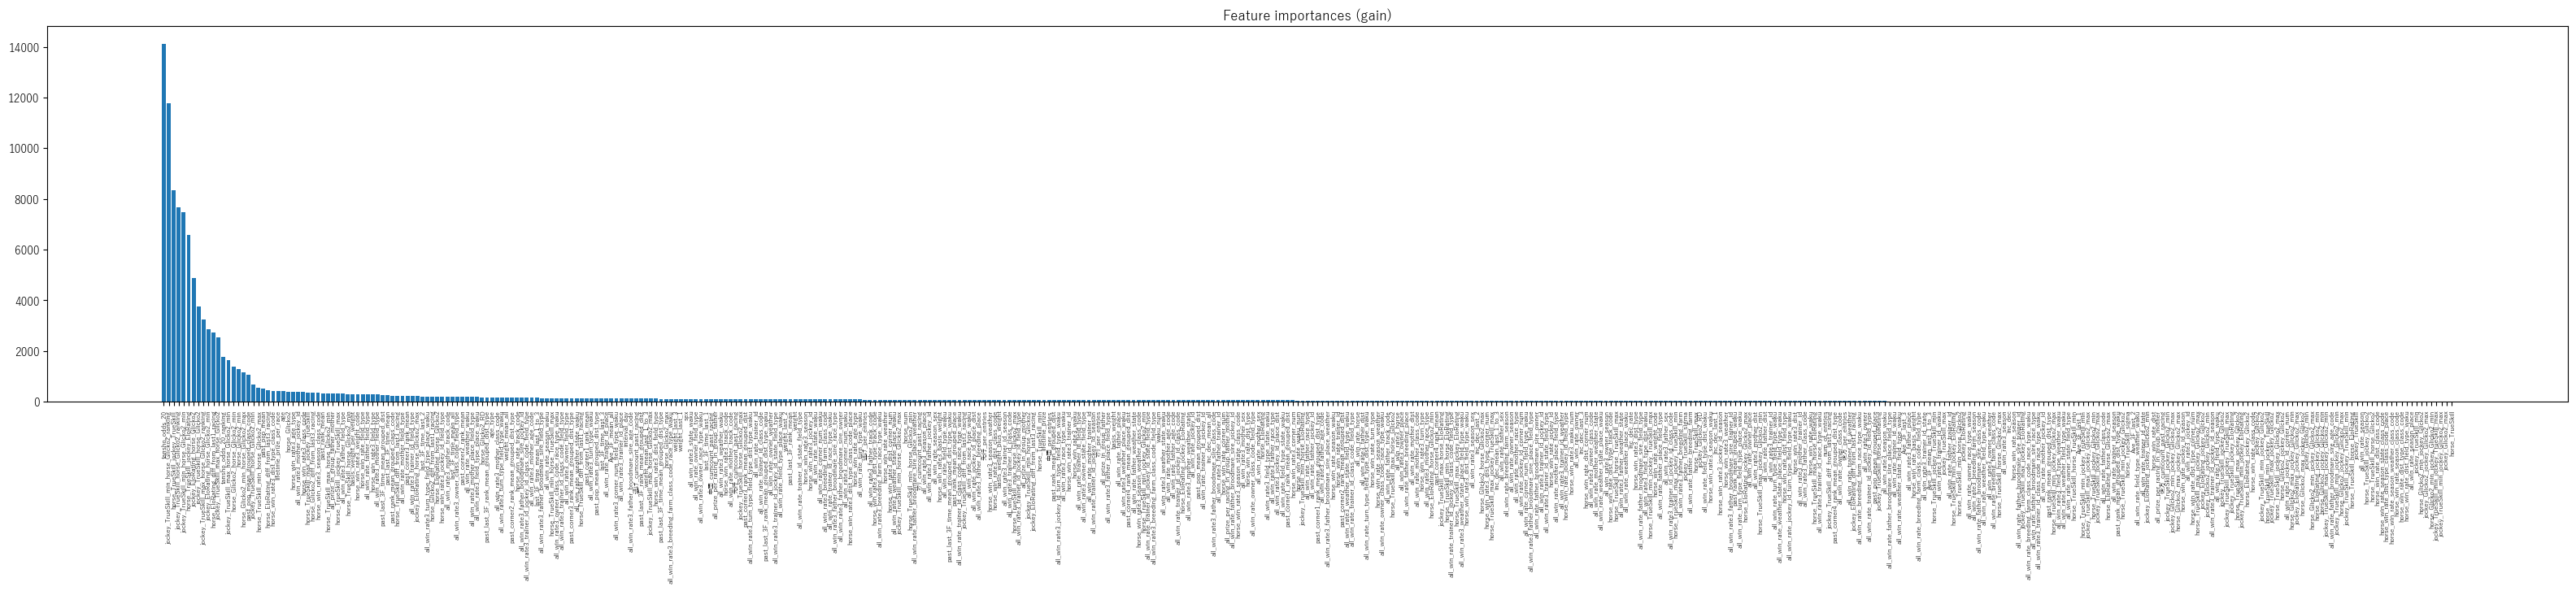

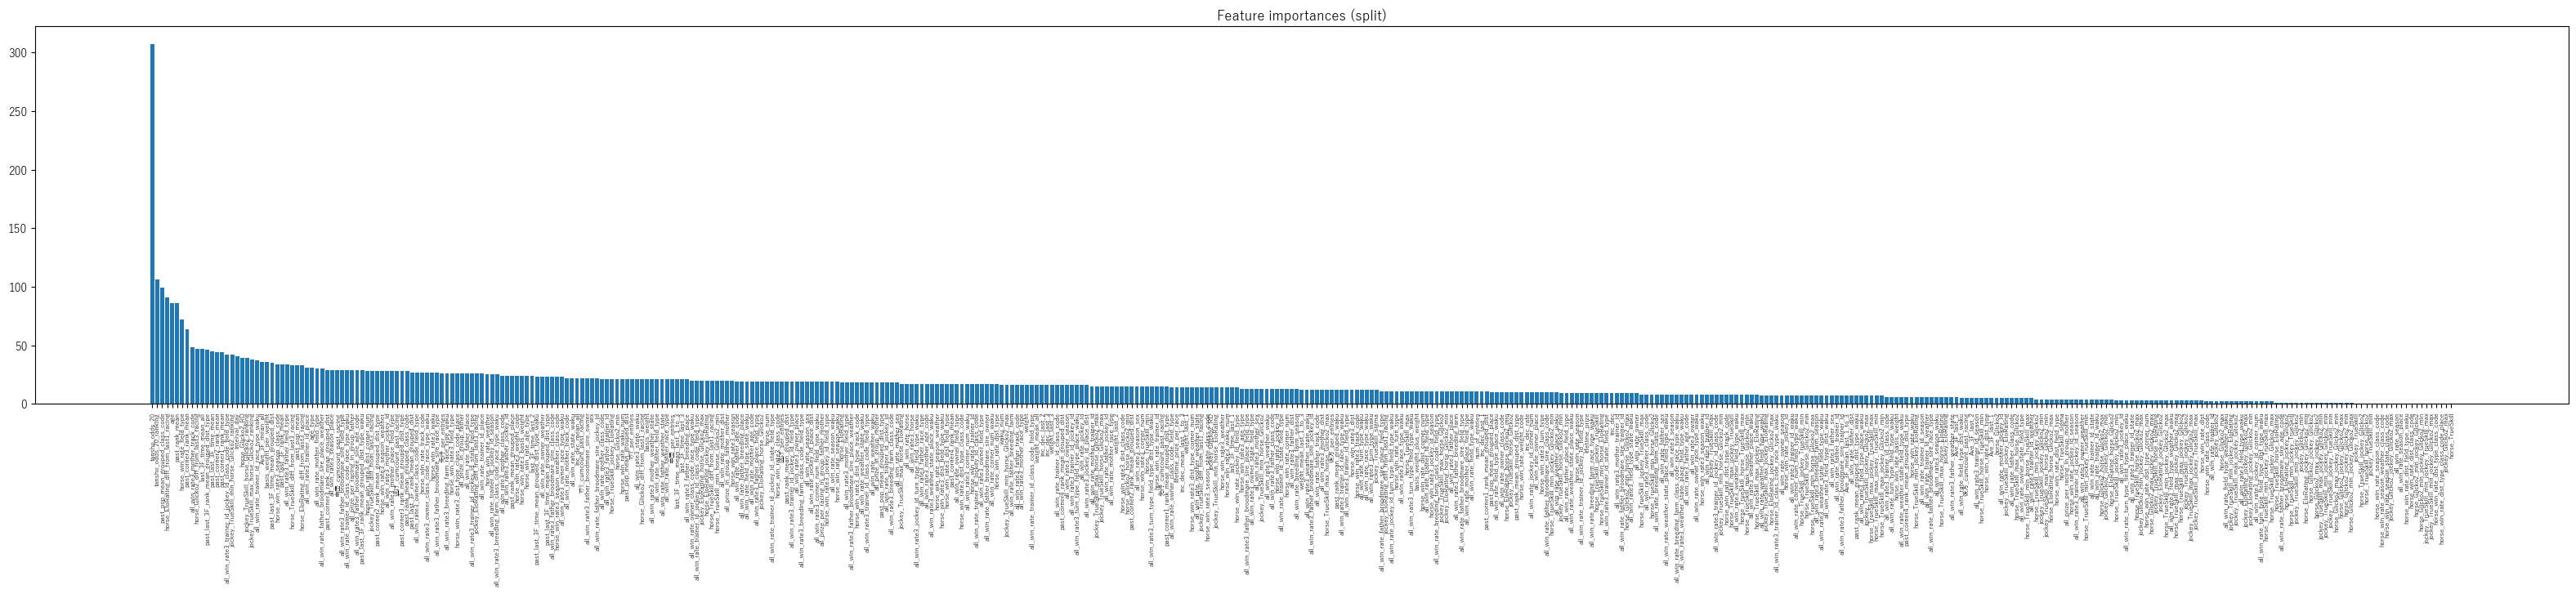

logloss is saved
auc_score is saved


,date,memo,horse_5,horse_6,horse_7,horse_8,horse_9,horse_10,horse_11,horse_12,horse_13,horse_14,horse_15,horse_16,horse_17,horse_18,all_logloss,auc(ovr)
0,2025/08/02 23:07,"reduce target_col, n_trials = 100",1.141415,1.109641,0.951733,0.961516,0.887865,0.815597,0.754253,0.708934,0.681193,0.658671,0.629718,0.588881,0.567198,0.544717,0.640888,0.769199
0,2025/08/01 23:37,"add group_horse_winning_rate more, n_trials = 100",1.242789,1.139266,0.963033,0.967749,0.888933,0.815373,0.752128,0.709626,0.680483,0.657611,0.628378,0.589077,0.567726,0.542474,0.640728,0.769630
1,2025/08/01 22:35,"add all ranking col, n_trials = 100",1.158936,1.080125,0.935652,0.933302,0.866713,0.810312,0.752405,0.707404,0.680145,0.656857,0.626544,0.587481,0.566945,0.539049,0.637647,0.772695
2,2025/08/01 21:22,"add group_horse_winning_rate more, n_trials = 100",1.257296,1.138452,0.964785,0.970762,0.892650,0.816663,0.753287,0.708726,0.680990,0.658595,0.628338,0.589314,0.566778,0.542536,0.641132,0.769221
3,2025/08/01 20:12,"add group_winning_rate more, n_trials = 100",1.244237,1.129139,0.963338,0.968867,0.890457,0.816323,0.752359,0.709507,0.680703,0.658065,0.629536,0.589707,0.566243,0.542621,0.641237,0.769135


In [17]:
memo = "reduce target_col, n_trials = 100"
model, df_pred = model_tuner_multi.multi_lightGBM(df5, feature_col3, memo=memo, n_trials=100, save_result=True, visualization=True)

In [ ]:
tmp = df_pred[["year", "month", "day", "horse", "pred_class_1", "pred_class_2", "pred_class_3", "target"]]
tmp.head(18)

In [ ]:
tmp = df_pred[["id_for_fold", "horse", "pred_class_1", "target"]].sort_values("pred_class_1", ascending=False)
tmp.head(10)

In [ ]:
importances = model.booster_.feature_importance(importance_type="gain")
feature_name = model.feature_name_
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_feature_name = [feature_name[i] for i in indices]

feature_df = pd.DataFrame({
    "feature": sorted_feature_name,
    "importances": sorted_importances
})

feature_df.head(300)

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df5[feature_col3])
shap.summary_plot(shap_values, df5[feature_col3], plot_type="bar", max_display=300)